In [150]:
import os
os.chdir('/home/evlasova/covid-t-cell-classifier')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from multipy.fwer import sidak, hochberg
import random

from source.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, \
                            plot_clonotype_clustering_with_epitope_labeling, plot_cooccurence_heatmap_with_epitopes_labeling_bubble
from source.usage_matrix_preprocessing import prepare_usage_matrix
from source.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, cross_validation_between_batches, make_hla_predictor
from source.data_utils import prepare_run_column
from source.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing
from source.clustering_utils import seqs2hamming, check_significant_epitopes_for_cluster, get_most_frequent_cluster_by_vdjdb_occurence
from source.weblogo_utils import create_web_logo
from math import sqrt


import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("source.viz_utils")
importlib.reload(imported_module)

<module 'source.viz_utils' from '/home/evlasova/covid-t-cell-classifier/source/viz_utils.py'>

In [83]:
vdjdb = pd.read_csv('data/vdjdb.txt', sep='\t')

In [4]:
desc = pd.read_csv('data/desc_fmba_not_nan_hla.csv').drop(columns=['Unnamed: 0'])
desc = desc[desc.COVID_status != 'unknown']
desc['covid'] = desc.COVID_status.apply(lambda x: 'covid' if x == 'COVID' else 'healthy')
desc

,run,reads,clonotypes,singletons,doubletons,file.id,sequencingDate,folder,R1,R2,...,HLA-DRB1.1,HLA-DRB1.2,id,subsequent_sequencing,HLA-DRB4.1,HLA-DRB3.1,HLA-DRB5.1,gene,is.bad.reseq,covid
0,020000010808_S3_L001.clonotypes.TRB.txt,623811,4324,491,263,020000010808_S3_L001,2020 10 19,2020/10_FMBA_NovaSeq5,020000010808_S3_L001_R1_001.fastq.gz,020000010808_S3_L001_R2_001.fastq.gz,...,DRB1*11:04,DRB1*16:01,020000010,NaN,NaN,NaN,NaN,TRB,NaN,covid
1,020000110808_S14_L001.clonotypes.TRB.txt,13119545,13264,573,219,020000110808_S14_L001,2020 09 05,2020/09_FMBA_NovaSeq_DNA,020000110808_S14_L001_R1_001.fastq.gz,020000110808_S14_L001_R2_001.fastq.gz,...,DRB1*01:01,DRB1*15:01,020000110,NaN,NaN,NaN,NaN,TRB,NaN,covid
2,020000190808_S27_L001.clonotypes.TRB.txt,6942203,16977,1198,550,020000190808_S27_L001,2020 10 19,2020/10_FMBA_NovaSeq5,020000190808_S27_L001_R1_001.fastq.gz,020000190808_S27_L001_R2_001.fastq.gz,...,DRB1*07:01,DRB1*15:02,020000190,NaN,NaN,NaN,NaN,TRB,NaN,covid
3,020000200808_S181_L002.clonotypes.TRB.txt,6583555,14220,916,420,020000200808_S181_L002,2020 10 19,2020/10_FMBA_NovaSeq5,020000200808_S181_L002_R1_001.fastq.gz,020000200808_S181_L002_R2_001.fastq.gz,...,DRB1*01:01,DRB1*04:04,020000200,NaN,NaN,NaN,NaN,TRB,NaN,healthy
4,020000280808_S59_L001.clonotypes.TRB.txt,2005779,6144,477,260,020000280808_S59_L001,2020 10 19,2020/10_FMBA_NovaSeq5,020000280808_S59_L001_R1_001.fastq.gz,020000280808_S59_L001_R2_001.fastq.gz,...,DRB1*01:03,DRB1*13:03,020000280,NaN,NaN,NaN,NaN,TRB,NaN,covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,780008510808_S152_L002.clonotypes.TRB.txt,125864,7215,1173,793,780008510808_S152_L002,2020 09 27,2020/09_FMBA_NovaSeq3_DNA,780008510808_S152_L002_R1_001.fastq.gz,780008510808_S152_L002_R2_001.fastq.gz,...,DRB1*07:01,DRB1*15:01,780008510,NaN,NaN,NaN,NaN,TRB,NaN,covid
964,780008550808_S150_L002.clonotypes.TRB.txt,3070841,8864,398,150,780008550808_S150_L002,2020 09 27,2020/09_FMBA_NovaSeq3_DNA,780008550808_S150_L002_R1_001.fastq.gz,780008550808_S150_L002_R2_001.fastq.gz,...,DRB1*04:01,DRB1*15:01,780008550,NaN,NaN,NaN,NaN,TRB,NaN,covid
965,910000140808_S123_L002.clonotypes.TRB.txt,3095012,27443,1318,643,910000140808_S123_L002,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,910000140808_S123_L002_R1_001.fastq.gz,910000140808_S123_L002_R2_001.fastq.gz,...,DRB1*03:01,DRB1*07:01,910000140,NaN,NaN,NaN,NaN,TRB,NaN,covid
966,910000320808_S121_L002.clonotypes.TRB.txt,203560,11451,2013,1299,910000320808_S121_L002,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,910000320808_S121_L002_R1_001.fastq.gz,910000320808_S121_L002_R2_001.fastq.gz,...,DRB1*01:02,DRB1*07:01,910000320,NaN,NaN,NaN,NaN,TRB,NaN,covid


# β chain biomarkers postprocessing

In [5]:
raw_beta_cm = pd.read_csv('data/hla_sign_clone_matrix/covid_clonotype_matrix_500k_top_1_mismatch_hla_all_fisher.csv').drop(columns=['Unnamed: 0'])

In [6]:
clean_beta_cm = pd.read_csv('data/hla_sign_clone_matrix/covid_clonotype_matrix_500k_top_1_mismatch_hla_all_fisher_wo_leaks_diagonal.csv').drop(columns=['Unnamed: 0'])

Preparing data/hla_sign_clone_matrix/covid_clonotype_matrix_500k_top_1_mismatch_hla_all_fisher.csv


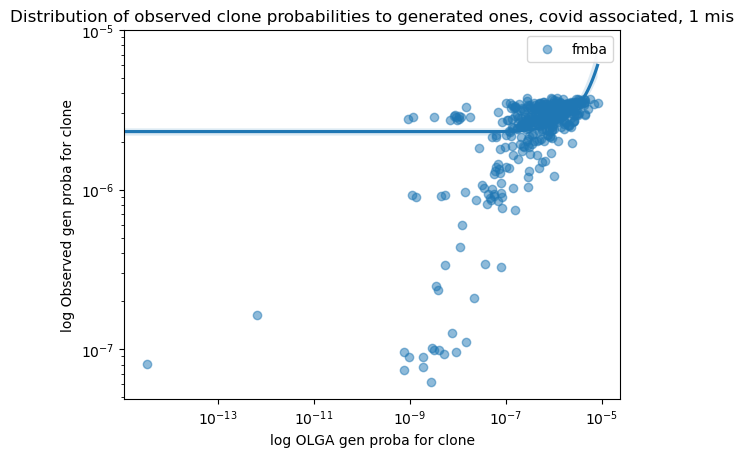

In [13]:
probas_beta = plot_generated_to_real_distribution(pgen_paths=['data/olga_pgen/fmba_pgen.tsv'], 
                                    cm_paths=['data/hla_sign_clone_matrix/covid_clonotype_matrix_500k_top_1_mismatch_hla_all_fisher.csv'], 
                                    desc='covid associated, 1 mis', 
                                    run_to_number_of_clones_path='data/run_to_number_of_clonotypes.csv', 
                                    labels=['fmba'])['fmba']

In [14]:
covid_clones_beta = pd.read_csv(
    'data/hla_sign_clone_matrix/covid_clonotype_matrix_500k_top_1_mismatch_hla_all_fisher_wo_leaks_diagonal.csv').drop(
    columns=['Unnamed: 0']).columns[:-1]
res_beta = seqs2hamming(covid_clones_beta, viz_method='graphopt')


In [46]:
beta_cluster_to_epi = {}
for cluster_index in range(22):
    beta_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_beta, cluster_index, dist=1, gene='TRB')

# α chain biomarkers postprocessing

In [15]:
clean_alpha_cm = pd.read_csv('data/alpha/covid_clonotype_matrix_500k_top_1_mismatch_hla_all_fisher_fmba_alpha_wo_leaks_diagonal.csv').drop(columns=['Unnamed: 0'])

In [16]:
raw_alpha_cm = pd.read_csv('data/alpha/covid_clonotype_matrix_500k_top_1_mismatch_hla_all_fisher_fmba_alpha.csv').drop(columns=['Unnamed: 0'])

Preparing data/alpha/covid_clonotype_matrix_500k_top_1_mismatch_hla_all_fisher_fmba_alpha.csv


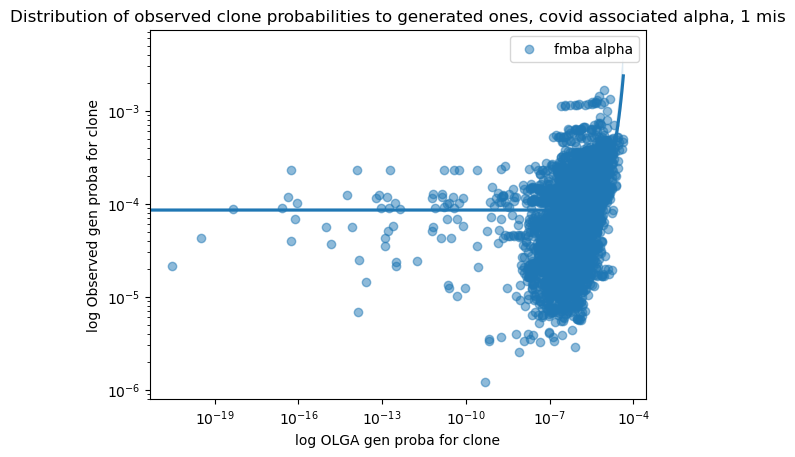

In [17]:
probas_alpha = plot_generated_to_real_distribution(pgen_paths=['data/olga_pgen/alpha_covid_pgen.tsv'], 
                                    cm_paths=['data/alpha/covid_clonotype_matrix_500k_top_1_mismatch_hla_all_fisher_fmba_alpha.csv'], 
                                    desc='covid associated alpha, 1 mis', 
                                    run_to_number_of_clones_path='data/run_to_number_of_clonotypes_alpha.csv', 
                                    labels=['fmba alpha'],
                                    make_bool_features=False)['fmba alpha']

In [18]:
covid_clones_alpha = pd.read_csv(
    'data/alpha/covid_clonotype_matrix_500k_top_1_mismatch_hla_all_fisher_fmba_alpha_wo_leaks_diagonal.csv').drop(
    columns=['Unnamed: 0']).columns[:-1]
res_alpha = seqs2hamming(covid_clones_alpha, viz_method='drl')


In [50]:
alpha_cluster_to_epi = {}
for cluster_index in range(138):
    alpha_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_alpha, cluster_index, dist=1, gene='TRA')

In [120]:
vdjdb[vdjdb['antigen.epitope'] == 'FLEGETLPT']

,complex.id,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,...,antigen.species,reference.id,method,meta,cdr3fix,vdjdb.score,web.method,web.method.seq,web.cdr3fix.nc,web.cdr3fix.unmp
85237,28091,TRA,CARMDSNYQLIW,TRAV6*01,TRAJ33*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,FLEGETLPT,...,SARS-CoV-2,PMID:34793243,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CARMDSNYQLIW"", ""cdr3_old"": ""CARMDSNY...",0,sort,singlecell,no,no
85238,28091,TRB,CASSQDPGPDTQYF,TRBV4-3*01,TRBJ2-3*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,FLEGETLPT,...,SARS-CoV-2,PMID:34793243,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSQDPGPDTQYF"", ""cdr3_old"": ""CASSQD...",0,sort,singlecell,no,no


In [121]:
alpha_cluster_to_epi[1]

,antigen.epitope,antigen.species,count
16,IPSINVHHY,CMV,13
23,LIIMRTFKV,SARS-CoV-2,19
0,AEVQIDRLI,SARS-CoV-2,21
43,TLIVNSVLL,SARS-CoV-2,21
22,LAMPFATPM,HomoSapiens,22
13,FPLCANGQV,SARS-CoV-2,23
39,RVVVLSFEL,SARS-CoV-2,23
10,FLEGETLPT,SARS-CoV-2,23
20,KQWLVWLFL,HomoSapiens,24
11,FLPGVYSVI,SARS-CoV-2,24


# α, β co-occorence analysis

In [19]:
cooccurence_df = pd.read_csv('data/clonotype_clustering/alpha_beta_cooccurence_matrix_pairing_80_cooccurence_85.csv').T
annot_df = pd.read_csv('data/clonotype_clustering/alpha_beta_paired_epitopes.csv').T

# plotting fig2

In [266]:
imported_module = importlib.import_module("source.clustering_utils")
importlib.reload(imported_module)
from source.clustering_utils import seqs2hamming, check_significant_epitopes_for_cluster

imported_module = importlib.import_module("source.viz_utils")
importlib.reload(imported_module)
from source.viz_utils import plot_clonotype_clustering_with_epitope_labeling, plot_cooccurence_heatmap_with_epitopes_labeling_bubble

up
up
MQVESDDYI
SLPGVFCGV


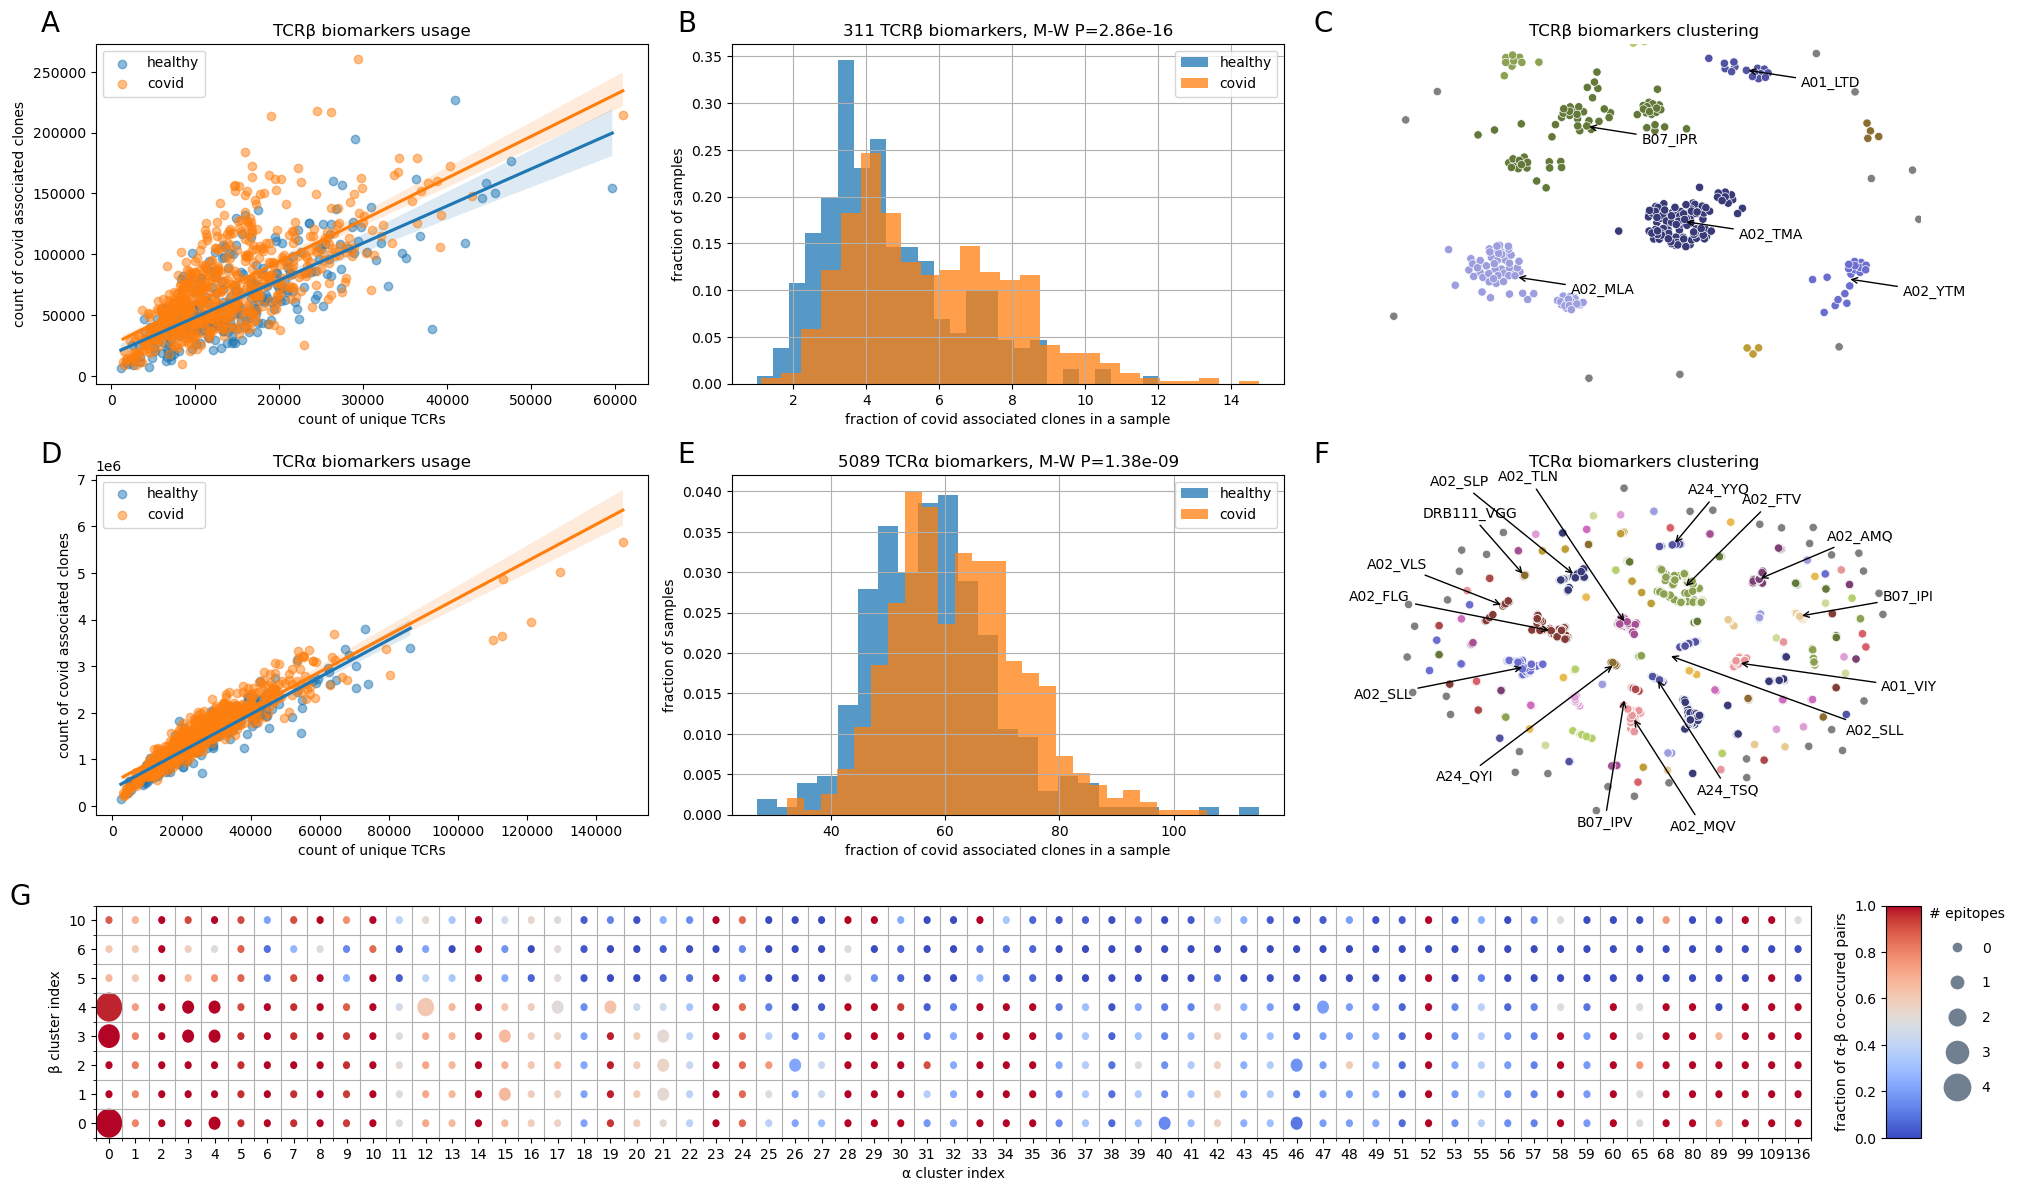

In [267]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
time = np.linspace(0, 10, 1000)
height = np.sin(time)
weight = time*0.3 + 2
score = time**2 + height
distribution = np.random.normal(0, 1, len(time))
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(nrows=11, 
              ncols=6)
font_size=20
delta_x=-0.1
delta_y=1.1

ax0 = fig.add_subplot(gs[:4, :2])
ax1 = fig.add_subplot(gs[:4, 2:4])
ax5 = fig.add_subplot(gs[:4, 4:])
significant_clones_distribution(significant_clonotype_matrix=clean_beta_cm, 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clonotypes_fmba_beta.csv'), 
                                desc=desc, 
                                data_description='TCRβ biomarkers',
                                by='covid',
                                reg_ax=ax0, 
                                hist_ax=ax1)
ax0.set_title('TCRβ biomarkers usage')
ax0.legend()
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)

# ax1.set_title('TCRβ biomarkers histogram')
ax1.legend()
ax1.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)

plot_clonotype_clustering_with_epitope_labeling(res_beta, beta_cluster_to_epi, vdjdb, gene='TRB', dist_to_center=50, global_zero_based=False, ax=ax5)
ax5.set_xlim(-500, 500)
ax5.set_ylim(-500, 500)
ax5.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)
ax5.axis('off')
ax5.set_title('TCRβ biomarkers clustering')

####################################################

ax2 = fig.add_subplot(gs[4:8, :2])
ax3 = fig.add_subplot(gs[4:8, 2:4])
ax6 = fig.add_subplot(gs[4:8, 4:])
significant_clones_distribution(significant_clonotype_matrix=clean_alpha_cm, 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clonotypes_alpha.csv'), 
                                desc=desc, 
                                data_description='TCRα biomarkers',
                                by='covid',
                                reg_ax=ax2, 
                                hist_ax=ax3)
ax2.set_title('TCRα biomarkers usage')
ax2.legend()
ax2.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)

# ax3.set_title('α biomarkers histogram')
ax3.legend()
ax3.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

plot_clonotype_clustering_with_epitope_labeling(res_alpha, 
                                                alpha_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRA', 
                                                cluster_size_threshold=50, 
                                                dist_to_center=450, 
                                                center_diff_threshold=75,
                                                ax=ax6)
ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)
ax6.axis('off')
ax6.set_xlim(-500, 500)
ax6.set_ylim(-500, 500)
ax6.set_title('TCRα biomarkers clustering')
###################################################

ax7 = fig.add_subplot(gs[8:, :])
plot_cooccurence_heatmap_with_epitopes_labeling_bubble(cooccurence_df, annot_df, fig=fig, ax=ax7)
ax7.text(delta_x+0.05, delta_y, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax7.transAxes,
        size=font_size)
###################################################
plt.tight_layout()
plt.savefig("figures/fig2.svg")
plt.savefig("figures/fig2.pdf")
plt.savefig("figures/fig2.png")
plt.show()

Figure 2. FMBA data TCRα and TCRβ biomarkers analysis.

A, D. Scatterplots comparing the distribution of the number of COVID-associated TCRβs/TCRαs to the total number of unique TCRβs/TCRαs sampled for COVID-19 patients and healthy donors.

B, E. Distribution of the number of COVID-associated TCRβs/TCRαs showing the significant difference in COVID-19 patients/ healthy donors.

C, F. Vizualization of COVID-associated TCRβs/TCRαs based on hamming distance. The closer the points are the less the hamming distance between the CDRs is.

G. Coouccurence of CDRs in α/β clusters. Coouccurence was calculated as the percent of TCRα/TCRβ pairs which are found together in more than 80% of samples which contain either the described TCRα, or TCRβ biomarker. The number in each cell of the matrix corresponds to the number of epitopes from VDJdb, which are found to be associated with both TCRα and TCRβ clusters.

# plotting supp fig 1

up
up


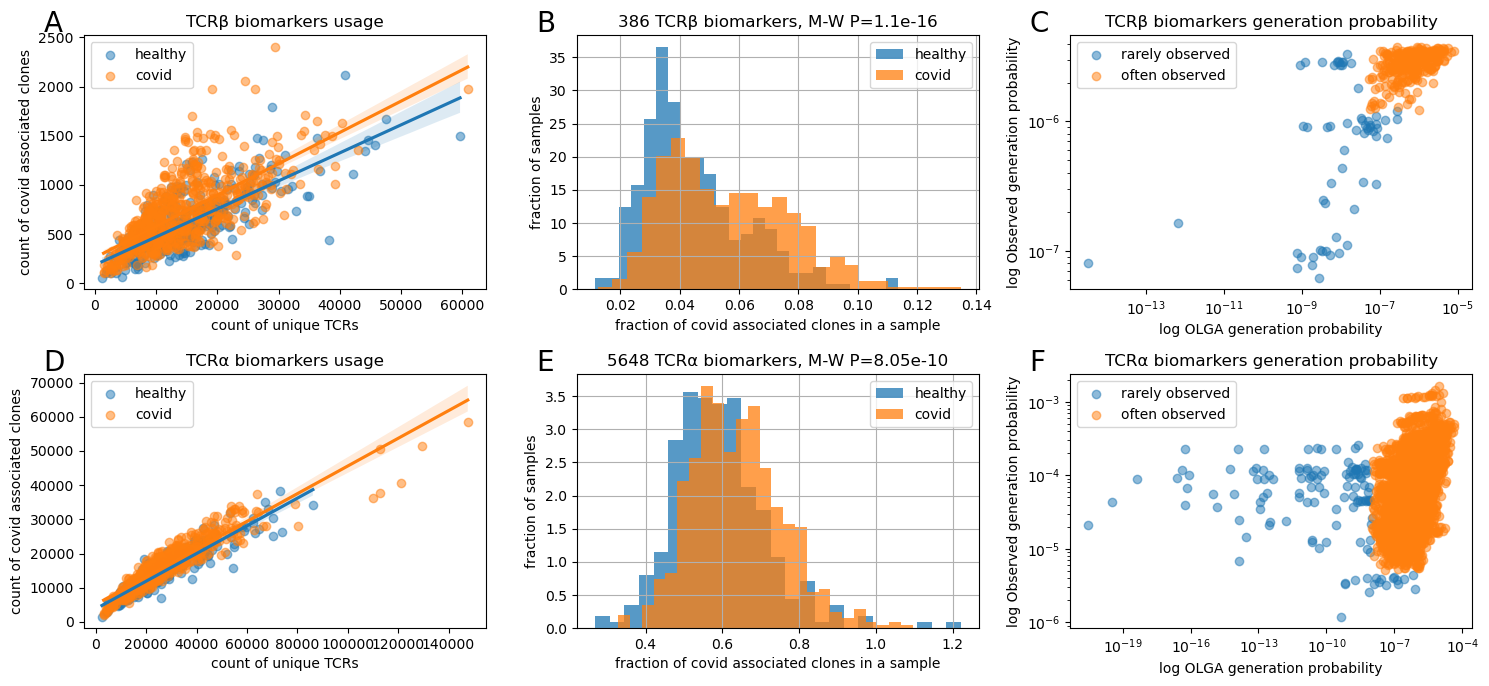

In [100]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(15, 20))
gs = GridSpec(nrows=6, 
              ncols=6)
font_size=20
delta_x=-0.1
delta_y=1.1

ax0 = fig.add_subplot(gs[0, :2])
ax1 = fig.add_subplot(gs[0, 2:4])
significant_clones_distribution(significant_clonotype_matrix=raw_beta_cm, 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clonotypes_fmba_beta.csv'), 
                                desc=desc, 
                                data_description='TCRβ biomarkers',
                                by='covid',
                                reg_ax=ax0, 
                                hist_ax=ax1)
ax0.set_title('TCRβ biomarkers usage')
ax0.legend()
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)

# ax1.set_title('TCRβ biomarkers histogram')
ax1.legend()
ax1.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)

ax4 = fig.add_subplot(gs[0, 4:])
plot_olga_cleanup_data(probas_beta, observed_threshold=1.2e-6, gen_threshold=3e-8, ax=ax4)
ax4.set_title('TCRβ biomarkers generation probability')
ax4.legend()
ax4.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)

####################################################

ax2 = fig.add_subplot(gs[1, :2])
ax3 = fig.add_subplot(gs[1, 2:4])
significant_clones_distribution(significant_clonotype_matrix=raw_alpha_cm, 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clonotypes_alpha.csv'), 
                                desc=desc, 
                                data_description='TCRα biomarkers',
                                by='covid',
                                reg_ax=ax2, 
                                hist_ax=ax3)
ax2.set_title('TCRα biomarkers usage')
ax2.legend()
ax2.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)

# ax3.set_title('α biomarkers histogram')
ax3.legend()
ax3.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)


ax5 = fig.add_subplot(gs[1, 4:])
plot_olga_cleanup_data(probas_alpha, observed_threshold=0.5e-5, gen_threshold=1e-8, ax=ax5)
ax5.set_title('TCRα biomarkers generation probability')
ax5.legend()
ax5.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)

###################################################

plt.tight_layout()
plt.savefig("figures/supp_fig1.svg")
plt.savefig("figures/supp_fig1.pdf")
plt.show()